# Imports and configs

In [39]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import glob
import gc
import time

warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "input/train.parquet"
    test_path = "input/test.parquet"
    sample_sub_path = "input/sample_submission.csv"

    target = "label"
    features_main = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
    features_x = ['X' + str(i) for i in range(1,890+1)]

    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 100 

# Data loading

Discussionで拾ってきたやつ。データ量を圧縮して分析効率を上げることができる。
https://www.kaggle.com/competitions/drw-crypto-market-prediction/discussion/580485

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2

    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe


In [5]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.drop(CFG.target, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3594.93 MB
--- Memory usage after: 961.92 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 3678.76 MB
--- Memory usage after: 984.36 MB
--- Decreased memory usage by 73.2%



# EDA

In [6]:
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
0,15.281250,8.421875,176.3750,44.96875,221.375,0.121277,-0.417725,0.005398,0.125977,0.058350,...,1.925781,1.847656,0.005676,0.190796,0.369629,0.377686,0.210205,0.159180,0.530762,0.562500
1,38.593750,2.335938,526.0000,322.00000,848.000,0.302734,-0.049561,0.356689,0.481201,0.237915,...,1.928711,1.849609,0.005226,0.184692,0.363525,0.374512,0.209595,0.158936,0.530273,0.533691
2,0.441895,60.250000,159.2500,136.37500,295.500,0.167480,-0.291260,0.083130,0.206909,0.101746,...,1.927734,1.849609,0.004795,0.178711,0.357666,0.371338,0.208984,0.158691,0.529785,0.546387
3,4.863281,21.015625,335.7500,124.93750,460.750,0.072937,-0.436523,-0.102478,0.017548,0.007149,...,1.928711,1.849609,0.004398,0.172974,0.351807,0.368408,0.208374,0.158569,0.529297,0.357666
4,27.156250,3.451172,98.4375,44.40625,142.875,0.173828,-0.213501,0.096069,0.215698,0.107117,...,1.926758,1.848633,0.004009,0.167358,0.345947,0.365234,0.207886,0.158325,0.529297,0.362549


### X変数と目的変数との相関を分析
* 目的変数 label：将来のマーケットのボラティリティを表す連続値
* 説明変数 X1~890：マスクされた変数

■わかっていること
* X697~717はinfinite values
* X864,X867,X869 ~ X872は0
* X変数同士で相関1のものがけっこうある

参考：https://www.kaggle.com/code/docxian/drw-crypto-prediction-explore-data#### 目的変数の分布

In [16]:

# ── 前処理 ──
# 数値列のみ抽出（X1～X200）重すぎるので。
X_num = X[CFG.features_x].select_dtypes(include=[np.number])

# ∞ を NaN に置換
X_num = X_num.replace([np.inf, -np.inf], np.nan)

# 欠損を各列の中央値で埋める
X_clean = X_num.fillna(X_num.median())

# まだ NaN を含む列を丸ごと除外
X_clean = X_clean.dropna(axis=1, how='any')

# float32 にダウンキャスト
X_clean = X_clean.astype(np.float32)

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

null_counts = X_clean.isnull().sum()
print(f"Null counts per column:")
print(null_counts[null_counts > 0])

X_clean.head()

Null counts per column:
Series([], dtype: int64)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X881,X882,X883,X884,X885,X886,X887,X888,X889,X890
0,0.121277,-0.417725,0.005398,0.125977,0.058350,0.027359,0.035767,0.068237,1.035156,-0.029572,...,1.000000,1.925781,1.847656,0.005676,0.190796,0.369629,0.377686,0.210205,0.159180,0.530762
1,0.302734,-0.049561,0.356689,0.481201,0.237915,0.208374,0.217041,0.249634,0.948730,-0.183472,...,1.002930,1.928711,1.849609,0.005226,0.184692,0.363525,0.374512,0.209595,0.158936,0.530273
2,0.167480,-0.291260,0.083130,0.206909,0.101746,0.072754,0.081543,0.114136,0.896484,-0.261719,...,1.002930,1.927734,1.849609,0.004795,0.178711,0.357666,0.371338,0.208984,0.158691,0.529785
3,0.072937,-0.436523,-0.102478,0.017548,0.007149,-0.021683,-0.012939,0.019638,0.732422,-0.535645,...,1.002930,1.928711,1.849609,0.004398,0.172974,0.351807,0.368408,0.208374,0.158569,0.529297
4,0.173828,-0.213501,0.096069,0.215698,0.107117,0.078979,0.087830,0.120422,0.763672,-0.430908,...,1.000977,1.926758,1.848633,0.004009,0.167358,0.345947,0.365234,0.207886,0.158325,0.529297


### 全体の相関

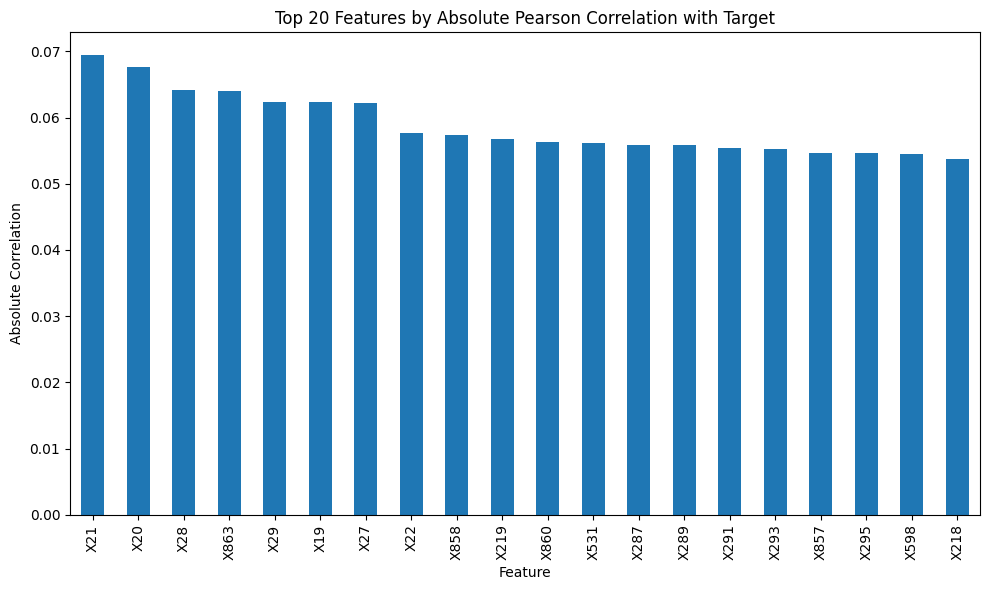

In [17]:
# Pearson correlation
corr = X_clean.corrwith(y)
corr_abs = corr.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_abs.iloc[:20].plot.bar()
plt.title('Top 20 Features by Absolute Pearson Correlation with Target')
plt.ylabel('Absolute Correlation')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

相関の最も強いX21でも0.07しかない。線形の相関は弱いため、非線形や相互作用との関係性があると想定される。　→ツリーやNNモデルが有効かもしれない。

In [18]:
import lightgbm as lgb

# 学習用データセットを作成
dtrain = lgb.Dataset(X_clean, label=y)

# GPUを使うためのパラメータ
params = {
    'objective': 'regression',   # 回帰問題
    'metric': 'rmse',            # 評価指標（RMSE）
    'device': 'gpu',             # ← ここでGPU指定
    'gpu_platform_id': 0,        # OpenCLプラットフォームID。通常は0
    'gpu_device_id': 0,          # GPUデバイスID。通常は0
    'learning_rate': 0.1,
    'num_leaves': 64,
    'max_depth': 7,
}

# ごく少量のブーストラウンドで動作確認
gbm = lgb.train(
    params,
    dtrain,
    num_boost_round=100,
    callbacks=[lgb.log_evaluation(5)]
)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 220058
[LightGBM] [Info] Number of data points in the train set: 525887, number of used features: 863
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 781 dense feature groups (393.20 MB) transferred to GPU in 0.110208 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.036126


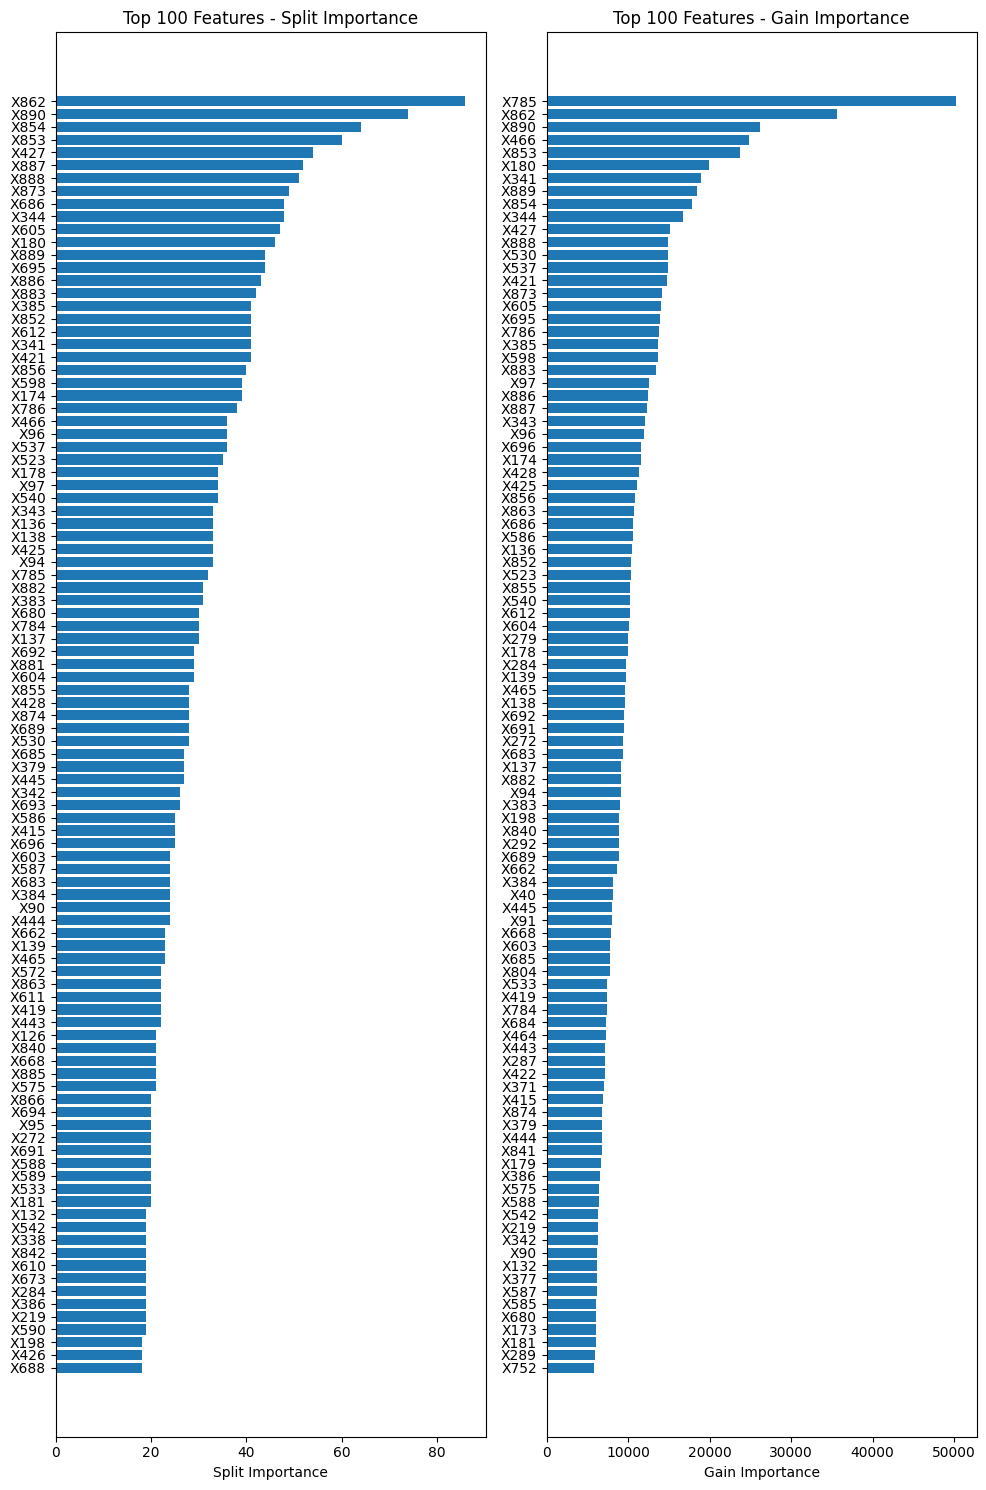

=== Top 10 Features by Gain Importance ===
    feature  gain_importance
763    X785     50270.891026
840    X862     35626.358002
868    X890     26132.450397
465    X466     24799.804146
831    X853     23685.499691
179    X180     19918.047003
340    X341     18978.687798
867    X889     18465.601849
832    X854     17780.974751
343    X344     16671.393936

=== Top 10 Features by Split Importance ===
    feature  split_importance
840    X862                86
868    X890                74
832    X854                64
831    X853                60
426    X427                54
865    X887                52
866    X888                51
851    X873                49
685    X686                48
343    X344                48

=== Importance Statistics ===
Total features: 869
Features with gain > 0: 647
Top feature (gain): X785 = 50270.8910


In [25]:
# LightGBM 変数重要度の取得と可視化
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split importance（分岐回数ベース）
split_importance = gbm.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({
    'feature': X_clean.columns,
    'split_importance': split_importance
}).sort_values('split_importance', ascending=False)

# 2. Gain importance（ゲインベース - より重要）
gain_importance = gbm.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({
    'feature': X_clean.columns,
    'gain_importance': gain_importance
}).sort_values('gain_importance', ascending=False)

# 3. 可視化
fig, axes = plt.subplots(1, 2, figsize=(10, 15))

# Split importance のプロット
axes[0].barh(split_importance_df.head(100)['feature'], 
             split_importance_df.head(100)['split_importance'])
axes[0].set_title('Top 100 Features - Split Importance')
axes[0].set_xlabel('Split Importance')
axes[0].invert_yaxis()

# Gain importance のプロット
axes[1].barh(gain_importance_df.head(100)['feature'], 
             gain_importance_df.head(100)['gain_importance'])
axes[1].set_title('Top 100 Features - Gain Importance')
axes[1].set_xlabel('Gain Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# 4. 上位重要度の数値表示
print("=== Top 10 Features by Gain Importance ===")
print(gain_importance_df.head(10))

print("\n=== Top 10 Features by Split Importance ===")
print(split_importance_df.head(10))

# 5. 重要度の要約統計
print(f"\n=== Importance Statistics ===")
print(f"Total features: {len(X_clean.columns)}")
print(f"Features with gain > 0: {(gain_importance > 0).sum()}")
print(f"Top feature (gain): {gain_importance_df.iloc[0]['feature']} = {gain_importance_df.iloc[0]['gain_importance']:.4f}")

# Feature Engineering

In [26]:
# 1. 上位100個の重要な特徴量を取得
top_100_features = gain_importance_df.head(100)['feature'].tolist()

# 2. CFG.features_mainと結合
# X_cleanから上位100個を取得
X_selected = X_clean[top_100_features].copy()

# CFG.features_mainを直接追加（nullがないことが確認済み）
X_main = X[CFG.features_main].copy().astype(np.float32)
X_selected = pd.concat([X_selected, X_main], axis=1)

print(f"上位100個の特徴量: {len(top_100_features)}")
print(f"CFG.features_main: {CFG.features_main}")
print(f"最終的な特徴量数: {X_selected.shape[1]}")
print(f"使用する特徴量: {X_selected.columns.tolist()}")

上位100個の特徴量: 100
CFG.features_main: ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
最終的な特徴量数: 105
使用する特徴量: ['X785', 'X862', 'X890', 'X466', 'X853', 'X180', 'X341', 'X889', 'X854', 'X344', 'X427', 'X888', 'X530', 'X537', 'X421', 'X873', 'X605', 'X695', 'X786', 'X385', 'X598', 'X883', 'X97', 'X886', 'X887', 'X343', 'X96', 'X696', 'X174', 'X428', 'X425', 'X856', 'X863', 'X686', 'X586', 'X136', 'X852', 'X523', 'X855', 'X540', 'X612', 'X604', 'X279', 'X178', 'X284', 'X139', 'X465', 'X138', 'X692', 'X691', 'X272', 'X683', 'X137', 'X882', 'X94', 'X383', 'X198', 'X840', 'X292', 'X689', 'X662', 'X384', 'X40', 'X445', 'X91', 'X668', 'X603', 'X685', 'X804', 'X533', 'X419', 'X784', 'X684', 'X464', 'X443', 'X287', 'X422', 'X371', 'X415', 'X874', 'X379', 'X444', 'X841', 'X179', 'X386', 'X575', 'X588', 'X542', 'X219', 'X342', 'X90', 'X132', 'X377', 'X587', 'X585', 'X680', 'X173', 'X181', 'X289', 'X752', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']


# Training base model

時系列データなので、シャッフルなしでクロスバリデーションしてみる。

In [ ]:
# 共通設定
kf = KFold(n_splits=CFG.n_folds, shuffle=False, random_state=None)

In [32]:
def pearson_score(y_true, y_pred):
    """Pearson相関スコア"""
    return pearsonr(y_true, y_pred)[0]

In [36]:

def run_cross_validation(model, X, y, model_name="Model", cv_folds=None):
    """
    fold別詳細結果表示対応クロスバリデーション関数
    
    Parameters:
    -----------
    model : sklearn compatible model
        学習させるモデル
    X : pandas.DataFrame
        特徴量データ
    y : pandas.Series
        目的変数
    model_name : str
        モデル名
    cv_folds : KFold object
        クロスバリデーション設定
    
    Returns:
    --------
    dict : CV結果の辞書
    """
    
    if cv_folds is None:
        cv_folds = KFold(n_splits=CFG.n_folds, shuffle=False, random_state=None)
    
    print(f"=== {model_name} Cross Validation 開始 ===")
    
    # 結果保存用
    fold_results = []
    rmse_scores = []
    r2_scores = []
    pearson_scores = []
    times = []
    
    # 各fold実行
    for fold, (train_idx, val_idx) in enumerate(cv_folds.split(X, y)):
        start_time = time.time()
        
        # データ分割
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # モデル学習
        model.fit(X_train, y_train)
        
        # 予測
        y_pred = model.predict(X_val)
        
        # 評価指標計算
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        pearson = pearsonr(y_val, y_pred)[0]
        
        # 実行時間
        fold_time = time.time() - start_time
        
        # 結果保存
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        pearson_scores.append(pearson)
        times.append(fold_time)
        
        fold_results.append({
            'fold': fold,
            'rmse': rmse,
            'r2': r2,
            'pearson': pearson,
            'time': fold_time
        })
        
        # fold別結果表示
        print(f"--- Fold {fold} - pearsonr: {pearson:.6f} - Time: {fold_time:.2f} s")
    
    # 全体統計
    results = {
        'fold_results': fold_results,
        'rmse': {
            'mean': np.mean(rmse_scores),
            'std': np.std(rmse_scores),
            'scores': rmse_scores
        },
        'r2': {
            'mean': np.mean(r2_scores),
            'std': np.std(r2_scores),
            'scores': r2_scores
        },
        'pearson': {
            'mean': np.mean(pearson_scores),
            'std': np.std(pearson_scores),
            'scores': pearson_scores
        },
        'time': {
            'mean': np.mean(times),
            'total': np.sum(times)
        }
    }
    
    # 全体結果表示
    print(f"\n{model_name} Overall Results:")
    print(f"  RMSE: {results['rmse']['mean']:.6f} ± {results['rmse']['std']:.6f}")
    print(f"  R²: {results['r2']['mean']:.6f} ± {results['r2']['std']:.6f}")
    print(f"  Pearson: {results['pearson']['mean']:.6f} ± {results['pearson']['std']:.6f}")
    print(f"  Total Time: {results['time']['total']:.2f} s")
    print()
    
    return results

## GBDT

In [37]:
print("📊 LightGBM学習開始")
lgbm_model = LGBMRegressor(
    objective='regression',
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    learning_rate=0.1,
    num_leaves=64,
    max_depth=7,
    n_estimators=1000,
    verbose=-1
)

lgbm_results = run_cross_validation(
    model=lgbm_model,
    X=X_selected,
    y=y,
    model_name="LightGBM",
    cv_folds=kf
)

📊 LightGBM学習開始
=== LightGBM Cross Validation 開始 ===
--- Fold 0 - pearsonr: 0.117976 - Time: 15.55 s
--- Fold 1 - pearsonr: 0.028456 - Time: 16.27 s
--- Fold 2 - pearsonr: 0.018516 - Time: 16.46 s
--- Fold 3 - pearsonr: 0.075793 - Time: 16.15 s
--- Fold 4 - pearsonr: 0.020841 - Time: 16.33 s

LightGBM Overall Results:
  RMSE: 1.308404 ± 0.294481
  R²: -0.741339 ± 0.786144
  Pearson: 0.052316 ± 0.038897
  Total Time: 80.77 s



最初のFold（時系列データの最初のブロックが検証データ）では0.1、それ以外ではピアソンが激減した。

In [38]:
print("📊 XGBoost学習開始")
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=1000,
    verbosity=0
)

xgb_results = run_cross_validation(
    model=xgb_model,
    X=X_selected,
    y=y,
    model_name="XGBoost",
    cv_folds=kf
)

📊 XGBoost学習開始
=== XGBoost Cross Validation 開始 ===
--- Fold 0 - pearsonr: 0.128510 - Time: 16.57 s
--- Fold 1 - pearsonr: 0.015100 - Time: 15.86 s
--- Fold 2 - pearsonr: 0.023430 - Time: 15.89 s
--- Fold 3 - pearsonr: 0.094066 - Time: 15.97 s
--- Fold 4 - pearsonr: 0.026883 - Time: 16.09 s

XGBoost Overall Results:
  RMSE: 1.334848 ± 0.345470
  R²: -0.837125 ± 0.975025
  Pearson: 0.057598 ± 0.045333
  Total Time: 80.38 s



LightGBMもXGBoostも結果はほぼ同じである。


## NN

In [41]:
# CPU用に最適化されたMLP
print("🏃‍♂️ 最適化MLP (CPU) 学習開始")

optimized_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 64),  # 層を減らして高速化
        activation='relu',
        solver='adam',
        alpha=0.01,  # 正則化を強めて過学習抑制
        batch_size=200,  # バッチサイズを大きくして高速化
        learning_rate='adaptive',
        learning_rate_init=0.01,
        max_iter=300,  # 反復数を減らして高速化
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20  # 早期停止を早めて高速化
    ))
])

optimized_mlp_results = run_cross_validation(
    model=optimized_mlp,
    X=X_selected,
    y=y,
    model_name="Optimized MLP (CPU)",
    cv_folds=kf
)

🏃‍♂️ 最適化MLP (CPU) 学習開始
=== Optimized MLP (CPU) Cross Validation 開始 ===
--- Fold 0 - pearsonr: 0.035753 - Time: 425.81 s
--- Fold 1 - pearsonr: -0.033505 - Time: 776.09 s
--- Fold 2 - pearsonr: 0.051116 - Time: 474.39 s
--- Fold 3 - pearsonr: -0.010259 - Time: 2767.38 s
--- Fold 4 - pearsonr: 0.048325 - Time: 34.87 s

Optimized MLP (CPU) Overall Results:
  RMSE: 1.562839 ± 0.159592
  R²: -1.413333 ± 0.423857
  Pearson: 0.018286 ± 0.034007
  Total Time: 4478.54 s



NNは処理が長すぎて中断